In [1]:
def fix_layout(width:int=95):
    from IPython.core.display import display, HTML
    display(HTML('<style>.container { width:' + str(width) + '% !important; }</style>'))
    
fix_layout()

In [2]:
import sys

import numpy as np
import matplotlib.pyplot as plt
from nnpde.utils.logs import enable_logging, logging 
from importlib import reload
import nnpde.functions.iterative_methods as im
from nnpde.functions import geometries, helpers
from nnpde.problems import DirichletProblem 

In [3]:
enable_logging(10)

2018-12-13 16:52:28,196 - root - INFO - logs - logging enabled for level: 10


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
# Define train dimension
N = 16

# Initialize f: we use a zero forcing term for training
f = torch.zeros(1, 1, N, N)

# For each problem instance define number of iteration to perform to obtain the solution
nb_problem_instances = 200
problem_instances = [DirichletProblem(k=k) for k in np.random.randint(1, 20, nb_problem_instances)]

Train using the class

In [6]:
import nnpde.model as M 

# TODO fit would idealy take X, y, (u_0 and u_*)
model = M.JacobyWithConv(max_iters=1000, batch_size=10).fit(problem_instances)
losses = model.losses

2018-12-13 16:52:59,820 - root - INFO - model - iter 0 with total loss 11495.650390625
2018-12-13 16:54:00,034 - root - INFO - model - iter 100 with total loss 10808.0595703125


KeyboardInterrupt: 

In [ ]:
print(losses)

In [ ]:
# TODO conv_u and Hu should be more or less the same, right? but they are clearly not...
some_u = problem_instances[0].initial_u

conv_u = model.net(some_u)

H = helpers.conv_net_to_matrix(model.net, model.N)

Hu = np.dot(H, some_u.view(-1).detach().numpy())

all((conv_u.view(-1).detach().numpy() - Hu) < 1e-4)

CHECK VALUES, now the error is very small , only problems may be at boundary nodes

In [ ]:
print(conv_u.view(-1).detach().numpy() - Hu)

In [ ]:
color_map = plt.get_cmap('cubehelix')
colors = color_map(np.linspace(0.1, 1, 10))

losses_fig = plt.figure()
n_iter = np.arange(np.shape(losses)[0])
plt.plot(n_iter[:], losses[:], color = colors[0], linewidth = 1, linestyle = "-", marker = "",  label='Loss')

plt.legend(bbox_to_anchor=(0., -0.3), loc=3, borderaxespad=0.)
plt.xlabel('n iteration', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Loss')
plt.grid(True, which = "both", linewidth = 0.5,  linestyle = "--")

print("final loss is {0}".format(losses[-1]))
#losses_fig.savefig('gridSearch.eps', bbox_inches='tight')

Train without using the class

In [14]:
from nnpde import metrics 
# Solve the same problem, at each iteration the only thing changing are the weights, which are optimized
# TODO why though? wouldn't it make much more sense to train it more times on different problems? isn't this the same as oversampling each training sample?
model = M.JacobyWithConv(max_iters=1000, batch_size=10)
net = model.net
optim = model.optim
losses = []
for _ in range(100):
    net.zero_grad()
    loss = torch.zeros(1)
    prev_total_loss = 0

    batch_size = 1
    u_list = [None] * batch_size
    
    # Sample problem_instances
    problem_idx = np.random.choice(np.arange(nb_problem_instances), batch_size, replace = 0)

    for i in range(batch_size):

        idx = problem_idx[i]
        problem_instance = problem_instances[idx]
        
        B_idx = problem_instance.B_idx
        B = problem_instance.B
        f = problem_instance.forcing_term
        initial_u = problem_instance.initial_u
        k = problem_instance.k
        ground_truth = problem_instance.ground_truth
        
        # Compute the solution with the updated weights      
        u_list[i] = im.H_method(net, B_idx, B, f, initial_u, k)
        
        #H = helpers.build_diagH_from_net(net,N)
        #T = helpers.get_T(N)
        #
        #spectral_norm = helpers.calculate_spectral_radius(T,H)
        #ex = 0
        #        
        #if spectral_norm > 1:
        #    ex = np.nan_to_num(np.inf)

        # Define the loss, CHECK if it is correct wrt paper
        loss = loss + F.mse_loss(ground_truth, u_list[i])#+ex
    


    # Backpropagation
    loss.backward(retain_graph =  False)

    # SGD step
    optim.step()
    
    total_loss = metrics.compute_loss(net, problem_instances,N)
    
    # Exit optimization 
    tol = 1e-2
    if total_loss.item() <= tol or total_loss.item() - prev_total_loss < tol:
        break


    # Store lossses for visualization
    losses.append(total_loss.item())
    prev_loss = total_loss.item()

for name, param in net.named_parameters():
    print(name, param)

0.weight Parameter containing:
tensor([[[[ 0.0087, -0.0980,  0.1728],
          [-0.2253, -0.3071, -0.2975],
          [ 0.0563,  0.2925,  0.3046]]]], requires_grad=True)
1.weight Parameter containing:
tensor([[[[ 0.2750, -0.1310,  0.1937],
          [-0.2808, -0.1800, -0.0048],
          [-0.2395,  0.0354,  0.0529]]]], requires_grad=True)
2.weight Parameter containing:
tensor([[[[-0.0281,  0.3216, -0.0385],
          [-0.1177,  0.0266,  0.0463],
          [-0.1073, -0.2548, -0.1340]]]], requires_grad=True)


Plot the losses

2018-12-13 16:58:40,402 - matplotlib.font_manager - DEBUG - font_manager - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/usr/share/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
2018-12-13 16:58:40,422 - matplotlib.font_manager - DEBUG - font_manager - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.0 to DejaVu Sans ('/usr/share/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
2018-12-13 16:58:40,452 - matplotlib.font_manager - DEBUG - font_manager - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/usr/share/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


final loss is 12303.9873046875


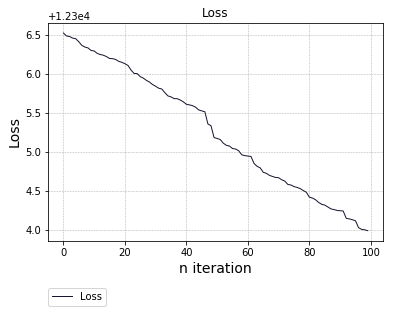

In [15]:
color_map = plt.get_cmap('cubehelix')
colors = color_map(np.linspace(0.1, 1, 10))

losses_fig = plt.figure()
n_iter = np.arange(np.shape(losses)[0])
plt.plot(n_iter[:], losses[:], color = colors[0], linewidth = 1, linestyle = "-", marker = "",  label='Loss')

plt.legend(bbox_to_anchor=(0., -0.3), loc=3, borderaxespad=0.)
plt.xlabel('n iteration', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Loss')
plt.grid(True, which = "both", linewidth = 0.5,  linestyle = "--")

print("final loss is {0}".format(losses[-1]))
#losses_fig.savefig('gridSearch.eps', bbox_inches='tight')

Test on a bigger grid

In [16]:
N = 50
nb_iters = 2000

B_idx, B = geometries.square_geometry(N)

# Set forcing term
f = torch.ones(1,1,N,N)*1.0

# Obtain solutions
gtt = im.jacobi_method(B_idx, B, f, torch.ones(1,1,N,N), k = 10000)
output = im.H_method(model.net, B_idx, B, f, torch.ones(1,1,N,N), k = nb_iters)
jacoby_pure = im.jacobi_method(B_idx, B, f, torch.ones(1,1,N,N), k = nb_iters)

In [17]:
loss_to_be_achieved = 1e-3

u_0 = torch.ones(1, 1, N, N)
net = model.net

In [18]:
%%timeit

u_k_old = im.jacobi_method(B_idx, B, f, u_0, k = 1)
loss_of_old = F.mse_loss(gtt, u_k_old)
k_count_old = 1
count_old = 1
# old method 
while loss_of_old >= loss_to_be_achieved:
    u_k_old = im.jacobi_method(B_idx, B, f, u_k_old, k = 1)
    loss_of_old = F.mse_loss(gtt, u_k_old)
    k_count_old += 1

952 ms ± 58.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit

u_k_new = im.H_method(net, B_idx, B, f, u_0, k=1)

loss_new = F.mse_loss(gtt, u_k_new)
k_count_new = 1


# new method

while loss_new >= loss_to_be_achieved:
    u_k_new = im.H_method(net, B_idx, B, f, u_k_new, k=1)
    loss_new = F.mse_loss(gtt, u_k_new)
    k_count_new += 1

In [ ]:
# This is not correct, but we have to look for a way to access the variables inside timeit

print("needed {0} iterations (compared to {1}), ratio: {2}".format(k_count_old, k_count_new, k_count_old/k_count_new))

In [ ]:
print("the loss of the new method is {0}, compared to the pure-jacoby one: {1}. computed with {2} iterations".format(F.mse_loss(gtt, output), F.mse_loss(gtt, jacoby_pure), nb_iters))

In [ ]:
helpers.plot_solution(gtt,output,N)

In [ ]:
(gtt.view(N,N) - output.view(N,N)).mean()

Test on L-shape domain

In [ ]:
B_idx, B = geometries.l_shaped_geometry(N)

# Set forcing term
f = torch.ones(1,1,N,N)*1.0

# Obtain solutions
gtt = im.jacobi_method(B_idx, B, f, torch.ones(1,1,N,N), k = 10000)
output = im.H_method(net, B_idx, B, f, torch.ones(1,1,N,N), k = 2000)

In [ ]:
helpers.plot_solution(gtt,output,N)